<img src=../figures/Brown_logo.svg width=50%>

## Data-Driven Design & Analyses of Structures & Materials (3dasm)

## Bayesian neural networks for uncertainty quantification at scale

### Miguel A. Bessa | <a href = "mailto: miguel_bessa@brown.edu">miguel_bessa@brown.edu</a>  | Associate Professor

### Jiaxiang Yi | PhD student

## Outline for today

* How to interpret Bayesian neural network compared to deterministic NN?
* How to integrate the posterior through Markov Chain Monte Carlo (MCMC)?


**Reading material**: This notebook + (Murphy's advanced book, chapter Part II Inference)

## Recap: ANN for regression with Gaussian prior
<img align=right src="./figures/recap.png" width=40%>


Assume a Gaussian prior  $\require{color} \color{red}p(z)$ on $\mathbf{w}$ and the MAP point estimate for an DNN

$$\require{color}
\hat{\mathbf{z}}_{\text{map}} = \underset{z}{\mathrm{argmin}}\left[-\log{p(\mathbf{y}=\mathbf{y}_n|\mathbf{x}=\mathbf{x}_n, \mathbf{z})} - \log{{\color{red}p(z)}}\right]$$


Performing the calculation, the point estimate when assuming a Gaussian prior becomes:

$$
\begin{align}
\hat{\mathbf{z}}_{\text{map}} = \underset{z}{\mathrm{argmin}}\left[\frac{1}{2} ||\mathbf{Y}-\mathbf{f}(\mathbf{X},\mathbf{z}) ||_2^2 + \alpha ||\mathbf{w}||_2^2\right]
\end{align}
$$

**Then, we can use sophisticated optimizers, as introduced in notebooks 25,26,27, for exploring the loss landscape (the right figure) to get a point estimation.**

## What if we want to get the posterior distributon of weights?

- Conceptually, from point estmation (DNN) to posterior distribution (BNN), we can inprepret we change the likelihood and prior from delta distribution to another distributions, like Gaussian distribution. 

 <img align=center src="./figures/dnnbnn.png" width=60%>


## What if we want to get the posterior distributon of weights?

- From an optimization view, instead of obtaining an optimum (shown in the left figure), it requires to integrate the whole loss (posterior distribution) landscape, as indicated in the second figure. 

 <img align=center src="./figures/OPTIMIZATION_VS_INFERENCE.png" width=60%>

## We then can formulate posterior with Bayes' rule?

\begin{align}
p\left( \mathbf{z} \mid \mathcal{D} \right) = \frac{p\left( \mathcal{D} \mid \mathbf{z} \right) p\left( \mathbf{z} \right)}{p\left( \mathcal{D} \right)} \propto p\left( \mathcal{D} \mid \mathbf{z} \right) \, p\left( \mathbf{z} \right)
\end{align}

- Likelihood: $
p\left( \mathcal{D} \mid \mathbf{z} \right)
= \mathcal{N}\!\left( \mathbf{Y} \,\middle|\, \mathbf{f}(\mathbf{X}, \mathbf{z}), \, \sigma^2 \mathbf{I} \right)
$, where $\sigma^2$ is the data noise.
- Prior:$
p\left( \mathbf{z} \right)
= \mathcal{N}\!\left( \mathbf{z} \,\middle|\, \mathbf{0}, \, \tau^2 \mathbf{I} \right)
$, where $\tau^2$ the variance of prior distribution.
- Log posterior can be derivated by:

\begin{align}
\log p\left( \mathbf{z} \mid \mathcal{D} \right) &= \log p\left( \mathcal{D} \mid \mathbf{z} \right) + \log p\left( \mathbf{z} \right)\\
&= \log \left[ \frac{\exp\left( -\frac{1}{2\sigma^2} 
    \left\| \mathbf{Y} - \mathbf{f}(\mathbf{X}, \mathbf{z}) \right\|_2^2 \right) }{(2\pi\sigma^2)^{n/2}} 
    \right]  + \log \left[ \frac{ \exp\left( -\frac{1}{2\tau^2} 
    \left\| \mathbf{w} \right\|_2^2 \right) }{(2\pi\tau^2)^{m/2}} \right] \\
&= -\frac{n}{2} \log(2\pi\sigma^2) 
   -\frac{1}{2\sigma^2} \left\| \mathbf{Y} - \mathbf{f}(\mathbf{X}, \mathbf{z}) \right\|_2^2  -\frac{m}{2} \log(2\pi\tau^2) 
   -\frac{1}{2\tau^2} \left\| \mathbf{w} \right\|_2^2
\end{align}

where $\frac{1}{2\tau^2}$ corresponds to the weight decay $\alpha$ in a deterministic setting

## How to integrate the posterior distribution? 

- The process of computing the posterior distribution over these variables based on observed data, following Bayes’ rule, is referred to as *inference*. 


- Once the likelihood, prior, and training data are fixed, the posterior distribution is also determined.


- On the other hand, changing any hyperparameter—such as replacing a Gaussian likelihood with another distribution or altering the data noise $\sigma^2$—will modify the posterior distribution. It is a higher-level Bayesian model training see Lecture 16.





### Markov Chain Monte Carlo (MCMC)


- A stochastic sampling method that constructs a Markov chain whose stationary distribution matches the target distribution $ p(\boldsymbol{\theta}) $. In the case of BNN, it is $p(\mathbf{z}|\mathcal{D})$.  
- It starts from an initial position $\boldsymbol{\theta}_0$ and generates candidate samples using a proposal distribution $ q(\boldsymbol{\theta}' \mid \boldsymbol{\theta}) $.  
- Each candidate is either accepted or rejected based on an acceptance rule (e.g., Metropolis–Hastings criterion), ensuring the chain explores the state space.  
- **Theoretical guarantee:** Under mild conditions (irreducibility, aperiodicity, detailed balance), the Markov chain converges to the target distribution as the number of iterations goes to infinity.  

 <img align=center src="./figures/ilustration_of_mcmc.png" width=30%> 



In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt

device = 'cpu' # run code in CPU (it's faster for the simple problems we are solving here)
# But if you want to use a GPU, you can uncomment the next line to automatically select the device:
#device = 'cuda' if torch.cuda.is_available() else 'cpu' 

# ------------------ Target Distribution ------------------ #
class TargetDistribution:
    """Mixture of Gaussians target distribution."""
    def __init__(self, w=np.array([0.2,0.4,0.3,0.1]), 
                 mu=np.array([-2.0,2.0,-4.0,0.6]),
                 sigma=np.array([1.0,1.0,1.2,0.4]), device='cpu'):
        self.device = device
        self.w = torch.tensor(w, dtype=torch.float32, device=device)
        self.mu = torch.tensor(mu, dtype=torch.float32, device=device)
        self.sigma = torch.tensor(sigma, dtype=torch.float32, device=device)
    
    def gaussian(self, x, mu, sigma):
        coef = 1.0 / (sigma * torch.sqrt(torch.tensor(2.0 * torch.pi, device=self.device)))
        exponent = -0.5 * ((x - mu) / sigma) ** 2
        return coef * torch.exp(exponent)

    def pdf(self, x):
        """Vectorized calculation of mixture pdf."""
        x = x.to(self.device).unsqueeze(-1)
        gauss_vals = self.gaussian(x, self.mu, self.sigma)
        return torch.sum(self.w * gauss_vals, dim=-1)

    def neg_log_pdf(self, x):
        return -torch.log(self.pdf(x))

    def plot_pdf(self, range_x=(-8,8), num_points=1000):
        x = torch.linspace(range_x[0], range_x[1], num_points, device=device)
        y = self.pdf(x)
        plt.figure(figsize=(5,4))
        plt.plot(x.cpu().numpy(), y.cpu().numpy(), label='Target PDF')
        plt.xlabel('x'); plt.ylabel('pdf'); plt.legend()
        plt.tight_layout(); plt.show()

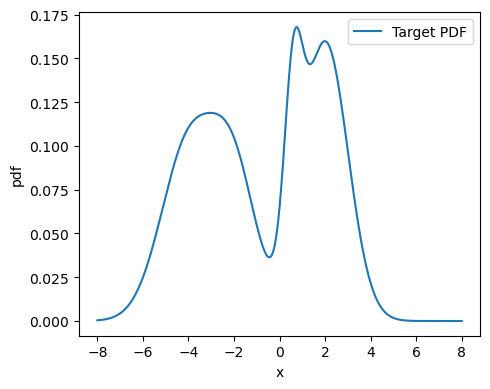

In [2]:
target  = TargetDistribution(w=np.array([0.2,0.4,0.3,0.1]), mu=np.array([-2.0,2.0,-4.0,0.6]),
                             sigma=np.array([1.0,1.0,1.2,0.4]), device=device)

target.plot_pdf()

In [3]:
class MetropolisHastings:
    def __init__(self, target_distribution, num_samples=2000, burn_in=200, proposal_std=1.0):
        self.target_distribution = target_distribution
        self.num_samples = num_samples
        self.burn_in = burn_in
        self.proposal_std = proposal_std
        self.device = device

    def run(self, num_trials=1, x0=None):
        self.trial_samples, self.full_chains, self.acceptance_rate = [], [], []

        for trial in range(num_trials):
            g = torch.Generator(device=self.device).manual_seed(1987 + trial)
            x = torch.randn((), generator=g, device=self.device) if x0 is None else torch.as_tensor(x0, device=self.device).reshape(())
            samples, full_chain = [], []
            accepts, accepts_post = 0, 0
            p_curr = self.target_distribution.pdf(x)

            for i in range(self.num_samples + self.burn_in):
                proposed_x = x + torch.randn((), generator=g, device=self.device) * self.proposal_std
                p_prop = self.target_distribution.pdf(proposed_x)
                alpha = torch.clamp(p_prop / (p_curr + 1e-12), max=1.0)

                if torch.rand((), generator=g, device=self.device) < alpha:
                    x = proposed_x
                    p_curr = p_prop
                    accepts += 1
                    if i >= self.burn_in:
                        accepts_post += 1

                full_chain.append(x.item())
                if i >= self.burn_in:
                    samples.append(x.item())

            rate = accepts / (self.num_samples + self.burn_in)
            rate_post = accepts_post / self.num_samples
            print(f'Trial {trial}: overall acceptance rate = {rate:.4f}, post burn-in = {rate_post:.4f}')

            self.trial_samples.append(torch.tensor(samples, device=self.device))
            self.full_chains.append(torch.tensor(full_chain, device=self.device))
            self.acceptance_rate.append(rate_post)

        return self.trial_samples
    
    # ------------------ Autocorrelation ------------------ #
    @staticmethod
    def autocorrelation(x, max_lag=100):
        x = np.asarray(x)
        x = x - np.mean(x)
        result = np.correlate(x, x, mode='full')
        acf = result[result.size//2:]
        acf = acf / acf[0]
        return acf[:max_lag+1]

    # ------------------ Plotting ------------------ #
    def plot_trials(self, bins=30, x_range=(-10,10), num_points=1000, max_lag=100):
        x_plot = torch.linspace(*x_range, num_points, device=self.device)
        pdf = self.target_distribution.pdf(x_plot).cpu().numpy()

        for i, (samples, chain) in enumerate(zip(self.trial_samples, self.full_chains)):
            fig = plt.figure(figsize=(12,4))
            gs = fig.add_gridspec(1, 2, width_ratios=[2,1])

            # Left: histogram + PDF
            ax0 = fig.add_subplot(gs[0,0])
            ax0.hist(samples.cpu().numpy(), bins=bins, density=True, alpha=0.6, label='Samples')
            ax0.plot(x_plot.cpu().numpy(), pdf, 'r--', lw=2, label='Target PDF')
            ax0.set_xlabel('x'); ax0.set_ylabel('Density'); ax0.set_title(f'Trial {i+1}: Histogram + PDF')
            ax0.legend()

            # Right: trace + autocorrelation
            gs_right = gs[0,1].subgridspec(2,1,hspace=0.7)

            # Trace plot
            ax1 = fig.add_subplot(gs_right[0,0])
            ax1.plot(chain.cpu().numpy(), lw=0.5)
            ax1.axvline(self.burn_in, color='red', ls='--', lw=1, label="Burn-in cutoff")
            ax1.set_xlabel('Iteration'); ax1.set_ylabel('x'); ax1.set_title('Trace plot'); ax1.legend()

            # Autocorrelation plot
            ax2 = fig.add_subplot(gs_right[1,0])
            acf = self.autocorrelation(samples.cpu().numpy(), max_lag=max_lag)
            ax2.stem(range(len(acf)), acf)
            ax2.set_xlabel('Lag'); ax2.set_ylabel('Autocorrelation'); ax2.set_title('Sample Autocorrelation')

            plt.tight_layout(); plt.show()

Trial 0: overall acceptance rate = 0.4925, post burn-in = 0.4918
Trial 1: overall acceptance rate = 0.4869, post burn-in = 0.4880
Trial 2: overall acceptance rate = 0.4886, post burn-in = 0.4892


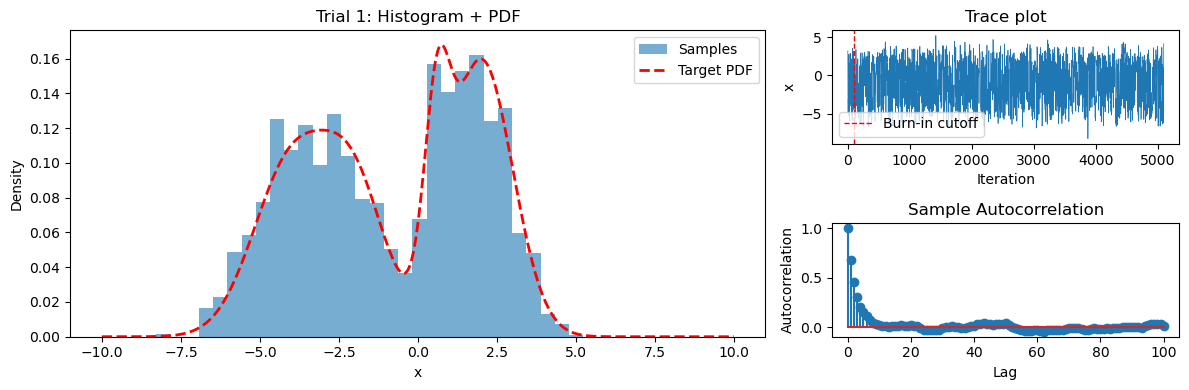

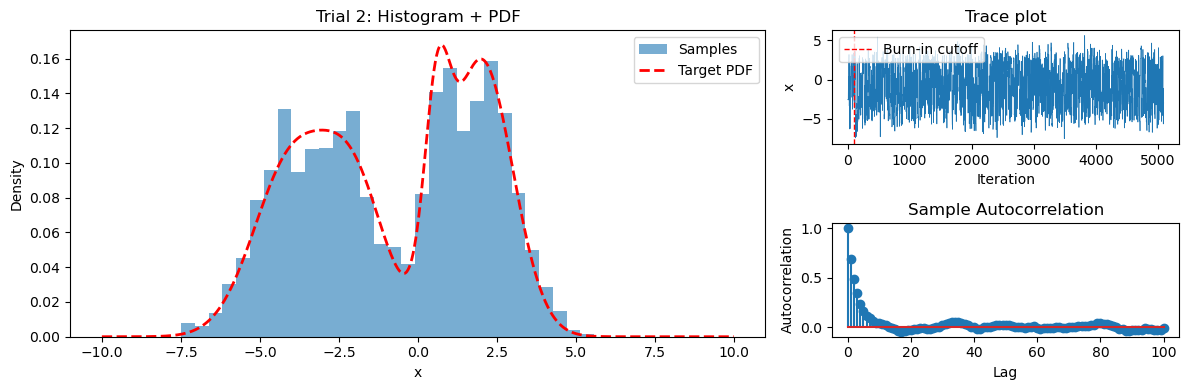

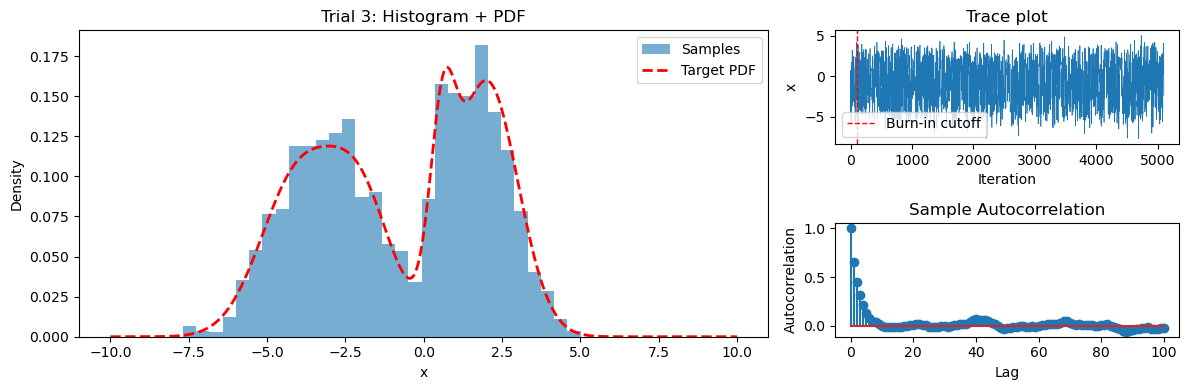

In [4]:
# play with the hyperparameters of RWMH algorithm: burn_in, proposal_std (a.k.a. step_size), number_samples
MH = MetropolisHastings(target_distribution=target,
                        num_samples=5000, 
                        burn_in=100, 
                        proposal_std=5.0)
# run 5 times the samples
results = MH.run(num_trials=3)
# plot the sampled pdf with the true one
MH.plot_trials(max_lag=100)

**Note about Autocorrelation measure in MCMC**

Autocorrelation function (ACF) helps diagnose Markov Chain Monte Carlo (MCMC) methods, including the Random Walk Metropolis–Hastings (RWMH) algorithm that we are discussing here. It helps us understand how "independent" the samples are and how efficiently the chain explores the target distribution.

Autocorrelation at lag $k$ is defined as:

$$\rho_k = \frac{\text{Cov}(x_t, x_{t+k})}{\text{Var}(x_t)}$$

- Measures how correlated a sample is with another sample $k$ steps later.
- $\rho_0 = 1$ (a sample is always perfectly correlated with itself).
- If $\rho_k \to 0$ quickly as $k$ increases, consecutive samples are nearly independent.

**Interpretation in MCMC:**  
- Low autocorrelation $\to$ samples explore the space efficiently and provide more independent information.  
- High autocorrelation $\to$ samples are highly dependent $\to$ need more iterations to get independent draws.

**Note about effect of proposal step size (`proposal_std`) in RWMH**

Small `proposal_std` (tiny steps)
- The sampler moves only slightly each iteration.  
- Consecutive samples are very similar $\to$ **high autocorrelation**.  
- Chain mixes slowly and can get "stuck" locally.  
- In the autocorrelation plot, $\rho_k$ remains high even for large lags.

Large `proposal_std` (big steps)
- Proposals jump farther, exploring the state space faster.  
- Consecutive samples are less correlated $\to$ **lower autocorrelation**.  
- If too large, many proposals are rejected $\to$ repeated samples $\to$ can also increase autocorrelation.  

**Key idea:** There is a **sweet spot** for `proposal_std` that balances acceptance rate and exploration.

**Practical Takeaways**

- **Low `proposal_std`** $\to$ slow exploration, high autocorrelation  
- **High `proposal_std`** $\to$ can move farther, lower autocorrelation, but watch acceptance rate  
- Autocorrelation plots are an excellent diagnostic to **check how well your sampler explores the target distribution**.

## Hamiltonian Monte Carlo (HMC)
- One fatal drawback of RWMH algorithm is that the random walk procedure prevents the scalability.

- Hamiltonian Monte Carlo (Neal 2012) improves the convergence, with embedding the concept of Hamitonian mechanics. 



<img src="figures/hmc.png" title="Hamiltonian mechanics" width="30%" align="right">
<!-- <img align=center src="./figures/hmc.png" width=20%>  -->
A Hamiltonian mechanical system can be imagined as a ball rolling in a frictionless bowl:
$$
\mathcal{H}\left(\boldsymbol{\theta}, \mathrm{v} \right) =
   \mathcal{\varepsilon(\boldsymbol{\theta})} + \mathcal{K}(\mathrm{v})
$$

- potential energy: $\mathcal{\varepsilon(\boldsymbol{\theta})} = - \log \, p(\boldsymbol{\theta})$

- kinetic energy: $\mathcal{K}(\mathrm{v}) = \frac{1}{2}\mathrm{v}^{T} {\Sigma}^{-1} \mathrm{v}$

where ${\Sigma}$ is the mass matrix.

**Key Idea**
- Uses Hamiltonian dynamics to propose new states by simulating trajectories shown in the figure
- **Efficiently explores** the target distribution by following energy-preserving paths.



### How to update position and velocity within Hamiltonian system: 

- **Euler's method**

$$\mathrm{v}_{t+1} = \mathrm{v}_{t} + \eta \frac{d\mathrm{v}(\mathrm{\theta}_t, \mathrm{v}_t)}{dt}= \mathrm{v}_{t}-\eta \frac{\partial \mathcal{\varepsilon}(\mathrm{\theta}_t)}{\partial \mathrm{\theta}} $$

$$\mathrm{\theta}_{t+1} = \mathrm{\theta}_{t} + \eta \frac{d\mathrm{\theta}(\mathrm{\theta}_t, \mathrm{v}_t)}{dt}= \mathrm{\theta}_{t}-\eta \frac{\partial \mathcal{K}(\mathrm{v}_t)}{\partial \mathrm{v}}$$

- **Modified Euler's method: _Improve accuracy_**

$$\mathrm{v}_{t+1} = \mathrm{v}_{t} + \eta \frac{d\mathrm{v}(\mathrm{\theta}_t, \mathrm{v}_t)}{dt}= \mathrm{v}_{t}-\eta \frac{\partial \mathcal{\varepsilon}(\mathrm{\theta}_t)}{\partial \mathrm{\theta}} $$

$$\mathrm{\theta}_{t+1} = \mathrm{\theta}_{t} + \eta \frac{d\mathrm{\theta}(\mathrm{\theta}_t, \mathrm{v}_{t+1})}{dt}= \mathrm{\theta}_{t}-\eta \frac{\partial \mathcal{K}(\mathrm{v}_{t+1})}{\partial \mathrm{v}}$$


### How to update position and velocity within Hamiltonian system: 

- **Leapfrog method:** *further improve the accuracy, with multiple leapfrog steps update*

$$\mathrm{v}_{t+\frac{1}{2}} =\mathrm{v}_{t}-\frac{\eta }{2}\frac{\partial \mathcal{\varepsilon}(\mathrm{\theta}_t)}{\partial \mathrm{\theta}} $$

$$\mathrm{\theta}_{t+1} =  \mathrm{\theta}_{t}+\eta \frac{\partial \mathcal{K}(\mathrm{v}_{t+\frac{1}{2}})}{\partial \mathrm{v}}$$

$$\mathrm{v}_{t+1} =\mathrm{v}_{t+\frac{1}{2}}-\frac{\eta }{2}\frac{\partial \mathcal{\varepsilon}(\mathrm{\theta}_{t+1})}{\partial \mathrm{\theta}} $$

In [5]:
from torch.autograd import grad

class HMC:
    def __init__(self,
                 potential_fn,    # negative log posterior
                 num_dim,
                 step_size=0.1,
                 leapfrog_steps=10,
                 num_samples=100,
                 burn_in=10,
                 device=None):
        """
        Hamiltonian Monte Carlo (HMC) sampler.

        Args:
            potential_fn: callable returning potential energy (negative log posterior)
            num_dim: dimensionality of parameter space
            step_size: leapfrog step size (ε)
            leapfrog_steps: number of leapfrog steps (L)
            num_samples: number of samples to collect (after burn-in)
            burn_in: number of burn-in iterations
            device: 'cpu' or 'cuda'. Computations done here.
        """
        self.potential_fn = potential_fn
        self.num_dim = num_dim
        self.step_size = step_size
        self.leapfrog_steps = leapfrog_steps
        self.num_samples = num_samples
        self.burn_in = burn_in
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')

    # -------------------------------
    # Energies
    # -------------------------------
    def potential_energy(self, x):
        """Compute potential energy U(x) = negative log posterior."""
        return self.potential_fn(x.to(self.device))

    def kinetic_energy(self, p):
        """Kinetic energy K(p) = 0.5 * p^T p (unit mass)."""
        return 0.5 * torch.sum(p ** 2)

    # -------------------------------
    # Gradient of potential
    # -------------------------------
    def grad_potential_energy(self, x):
        x = x.clone().detach().requires_grad_(True)
        U = self.potential_energy(x)
        grad_U = grad(U, x, create_graph=False)[0]
        return grad_U

    # -------------------------------
    # Leapfrog integrator
    # -------------------------------
    def leapfrog(self, x, p):
        x = x.clone()
        p = p.clone()

        # half-step momentum update
        p -= 0.5 * self.step_size * self.grad_potential_energy(x)

        # full-step updates
        for i in range(self.leapfrog_steps):
            x += self.step_size * p  # full step for position
            if i != self.leapfrog_steps - 1:
                p -= self.step_size * self.grad_potential_energy(x)

        # final half-step momentum
        p -= 0.5 * self.step_size * self.grad_potential_energy(x)

        return x, -p  # negate momentum for reversibility

    # -------------------------------
    # Sampling
    # -------------------------------
    def sample(self, init_position=None):
        total_iters = self.num_samples + self.burn_in

        # Preallocate storage on device for efficiency
        self.chain_potential = torch.empty(total_iters, device=self.device)
        self.chain_samples = torch.empty((total_iters, self.num_dim), device=self.device)

        samples = []
        accept_count = 0

        # Initial position
        if init_position is None:
            x = torch.randn(self.num_dim, device=self.device)
        else:
            x = init_position.to(self.device).reshape(-1)

        for i in range(total_iters):
            x = x.detach()
            p = torch.randn(self.num_dim, device=self.device)

            cur_U = self.potential_energy(x)
            cur_K = self.kinetic_energy(p)

            # propose new state
            x_prop, p_prop = self.leapfrog(x, p)
            prop_U = self.potential_energy(x_prop)
            prop_K = self.kinetic_energy(p_prop)

            # Metropolis acceptance
            accept_prob = torch.exp(cur_U - prop_U + cur_K - prop_K)
            if torch.rand(1, device=self.device) < accept_prob:
                x = x_prop
                accepted = True
            else:
                accepted = False

            # store chain (potential on device, samples on device)
            self.chain_potential[i] = cur_U
            self.chain_samples[i] = x

            # collect posterior samples on CPU (memory-efficient)
            if i >= self.burn_in:
                samples.append(x.cpu())
                if accepted:
                    accept_count += 1

        acceptance_rate = accept_count / self.num_samples
        return torch.stack(samples), acceptance_rate

    # -------------------------------
    # Full chain access
    # -------------------------------
    def get_chain_samples(self):
        """Return all chain samples (burn-in included). Already on device."""
        return self.chain_samples

In [6]:
# -------------------------------
# Plotting HMC results
# -------------------------------
def plot_hmc_results(all_samples, hmc_objects, target, x_range=(-8,8), bins=30):
    """
    Plot results of multiple HMC runs.

    Left: histogram + target PDF
    Right: stacked trace + potential energy
    """
    for i, (samples, hmc) in enumerate(zip(all_samples, hmc_objects)):
        fig = plt.figure(figsize=(12,4))
        gs = fig.add_gridspec(1,2,width_ratios=[2,1])

        # -------------------------------
        # Histogram + target PDF
        # -------------------------------
        ax0 = fig.add_subplot(gs[0,0])
        ax0.hist(samples.cpu().numpy(), bins=bins, density=True, alpha=0.6, label='Samples')
        x_plot = torch.linspace(*x_range, 1000)  # CPU tensor
        ax0.plot(x_plot.numpy(), target.pdf(x_plot).cpu().numpy(),
                 'r--', lw=2, label='Target PDF')
        ax0.set_xlabel('x'); ax0.set_ylabel('Density'); ax0.set_title(f'Trial {i+1}: Histogram + PDF')
        ax0.legend()

        # -------------------------------
        # Trace + potential energy
        # -------------------------------
        gs_right = gs[0,1].subgridspec(2,1,hspace=0.7)

        # Trace
        ax1 = fig.add_subplot(gs_right[0,0])
        ax1.plot(hmc.get_chain_samples().cpu().numpy(), lw=0.5)
        ax1.axvline(hmc.burn_in, color='red', ls='--', lw=1, label='Burn-in cutoff')
        ax1.set_xlabel('Iteration'); ax1.set_ylabel('x'); ax1.set_title('Trace plot'); ax1.legend()

        # Potential energy
        ax2 = fig.add_subplot(gs_right[1,0])
        ax2.plot(hmc.chain_potential.cpu().numpy(), lw=0.5, color='orange')
        ax2.axvline(hmc.burn_in, color='red', ls='--', lw=1)
        ax2.set_xlabel('Iteration'); ax2.set_ylabel('Potential energy'); ax2.set_title('Potential energy (NLL)')

        plt.tight_layout()
        plt.show()

Run 1 - Acceptance Rate: 1.0000
Run 2 - Acceptance Rate: 1.0000
Run 3 - Acceptance Rate: 1.0000


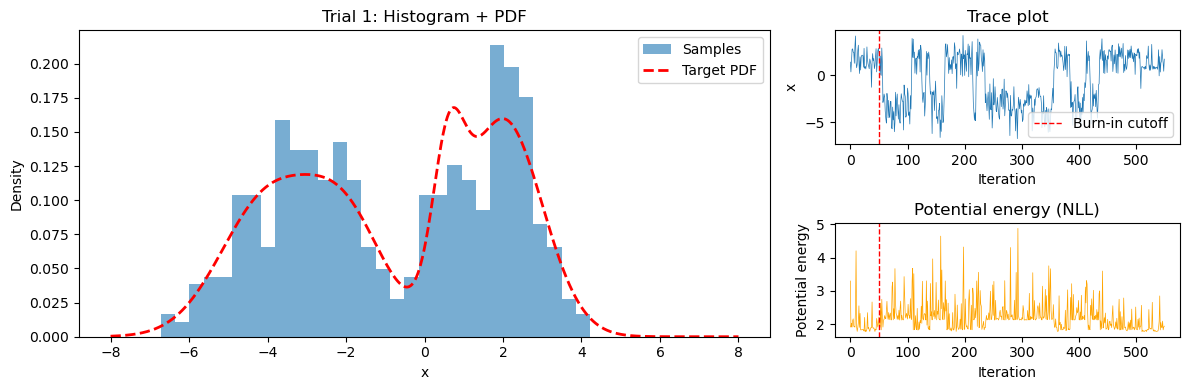

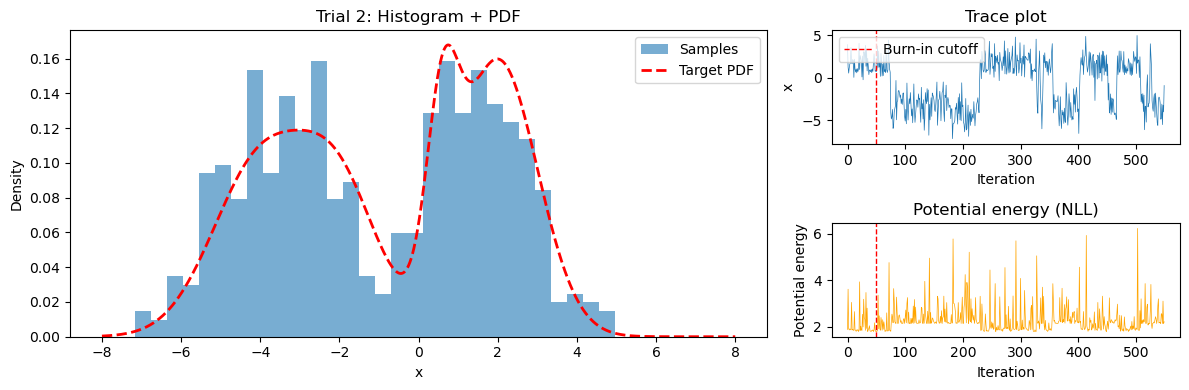

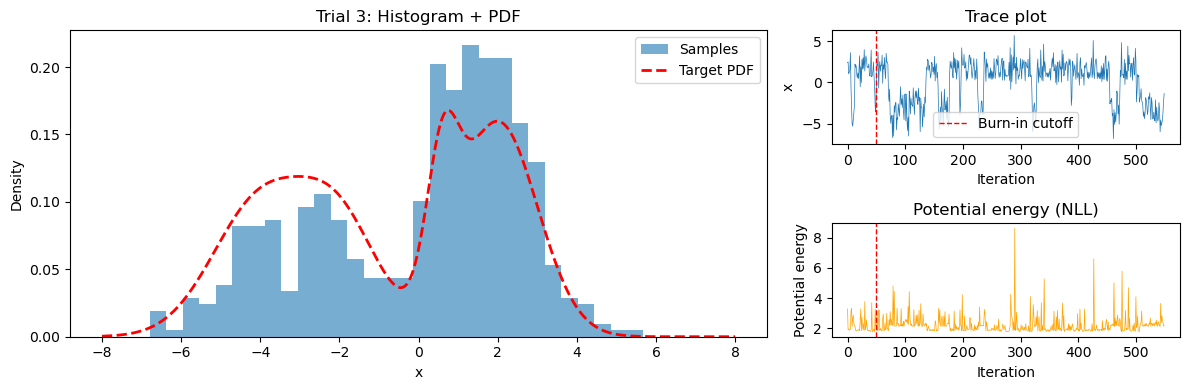

In [7]:
# -------------------------------
# Run HMC multiple times
# -------------------------------
all_samples = []   # store posterior samples (CPU)
hmc_objs = []      # store HMC objects for trace/potential visualization

num_runs = 3
for run in range(num_runs):
    # Initialize HMC sampler
    hmc = HMC(
        potential_fn=target.neg_log_pdf,  # negative log density (potential energy)
        num_dim=1,                         # dimensionality of x
        step_size=0.1,                     # leapfrog step size
        leapfrog_steps=20,                 # number of leapfrog steps
        num_samples=500,                   # number of posterior samples
        burn_in=50,                         # burn-in iterations
        device=device                       # compute device ('cuda' or 'cpu')
    )

    # Sample from the posterior
    samples, acc_rate = hmc.sample()
    print(f"Run {run+1} - Acceptance Rate: {acc_rate:.4f}")

    # Store results
    all_samples.append(samples.view(-1))  # keep samples on CPU for plotting
    hmc_objs.append(hmc)

# -------------------------------
# Plot results
# -------------------------------
plot_hmc_results(all_samples, hmc_objs, target, x_range=(-8, 8), bins=30)

We can also compare the two sampling methods for equivalent hyperparameters.

In [8]:
import time

# ----------------- RWMH Sampling ----------------- #
start_time = time.time()
MH = MetropolisHastings(target_distribution=target,
                        num_samples=2000, 
                        burn_in=200, 
                        proposal_std=1.0)
rwmh_samples = MH.run(num_trials=1)
rwmh_time = time.time() - start_time
print(f"RWMH took {rwmh_time:.2f} seconds")
print(f"RWMH acceptance rate (post burn-in): {MH.acceptance_rate[0]:.4f}")

# ----------------- HMC Sampling ----------------- #
start_time = time.time()
hmc = HMC(potential_fn=target.neg_log_pdf,
          num_dim=1,
          step_size=0.1,
          leapfrog_steps=20,
          num_samples=2000,
          burn_in=200,
          device=device)
hmc_samples, hmc_acc_rate = hmc.sample()
hmc_time = time.time() - start_time
print(f"HMC took {hmc_time:.2f} seconds")
print(f"HMC acceptance rate (post burn-in): {hmc_acc_rate:.4f}")

Trial 0: overall acceptance rate = 0.8000, post burn-in = 0.7985
RWMH took 0.14 seconds
RWMH acceptance rate (post burn-in): 0.7985
HMC took 9.44 seconds
HMC acceptance rate (post burn-in): 0.9995


In [9]:
def plot_sampler_comparison(rwmh_samples, hmc_samples, target, bins=30, x_range=(-8,8), max_lag=100):
    """
    Compare RWMH and HMC samples:
    - Histograms + target PDF
    - Trace plots
    - Autocorrelation
    """
    # Flatten samples for plotting / autocorr
    rwmh_flat = rwmh_samples[0].cpu().numpy().ravel()
    hmc_flat = hmc_samples.cpu().numpy().ravel()

    # x values for PDF
    x_vals = torch.linspace(*x_range, 1000, device=device)
    pdf_vals = target.pdf(x_vals).cpu().numpy()

    fig, axes = plt.subplots(3, 2, figsize=(12, 10))

    # ---------------- Histograms + PDF ---------------- #
    axes[0,0].hist(rwmh_flat, bins=bins, density=True, alpha=0.6, label='RWMH')
    axes[0,0].plot(x_vals.cpu().numpy(), pdf_vals, 'r--', lw=2, label='Target PDF')
    axes[0,0].set_title("RWMH Histogram + PDF"); axes[0,0].legend()

    axes[0,1].hist(hmc_flat, bins=bins, density=True, alpha=0.6, label='HMC')
    axes[0,1].plot(x_vals.cpu().numpy(), pdf_vals, 'r--', lw=2, label='Target PDF')
    axes[0,1].set_title("HMC Histogram + PDF"); axes[0,1].legend()

    # ---------------- Trace plots ---------------- #
    axes[1,0].plot(rwmh_flat, lw=0.5)
    axes[1,0].axvline(MH.burn_in, color='red', ls='--', lw=1, label='Burn-in')
    axes[1,0].set_title("RWMH Trace"); axes[1,0].legend()

    axes[1,1].plot(hmc_flat, lw=0.5)
    axes[1,1].axvline(hmc.burn_in, color='red', ls='--', lw=1, label='Burn-in')
    axes[1,1].set_title("HMC Trace"); axes[1,1].legend()

    # ---------------- Autocorrelation ---------------- #
    def autocorr(x, max_lag=max_lag):
        x = np.asarray(x)
        x = x - np.mean(x)
        result = np.correlate(x, x, mode='full')
        acf = result[result.size // 2:]
        acf /= acf[0]
        return acf[:max_lag+1]

    acf_rwmh = autocorr(rwmh_flat, max_lag)
    acf_hmc = autocorr(hmc_flat, max_lag)

    axes[2,0].stem(range(len(acf_rwmh)), acf_rwmh, basefmt=" ")
    axes[2,0].set_title("RWMH Autocorrelation")
    axes[2,1].stem(range(len(acf_hmc)), acf_hmc, basefmt=" ")
    axes[2,1].set_title("HMC Autocorrelation")

    plt.tight_layout()
    plt.show()

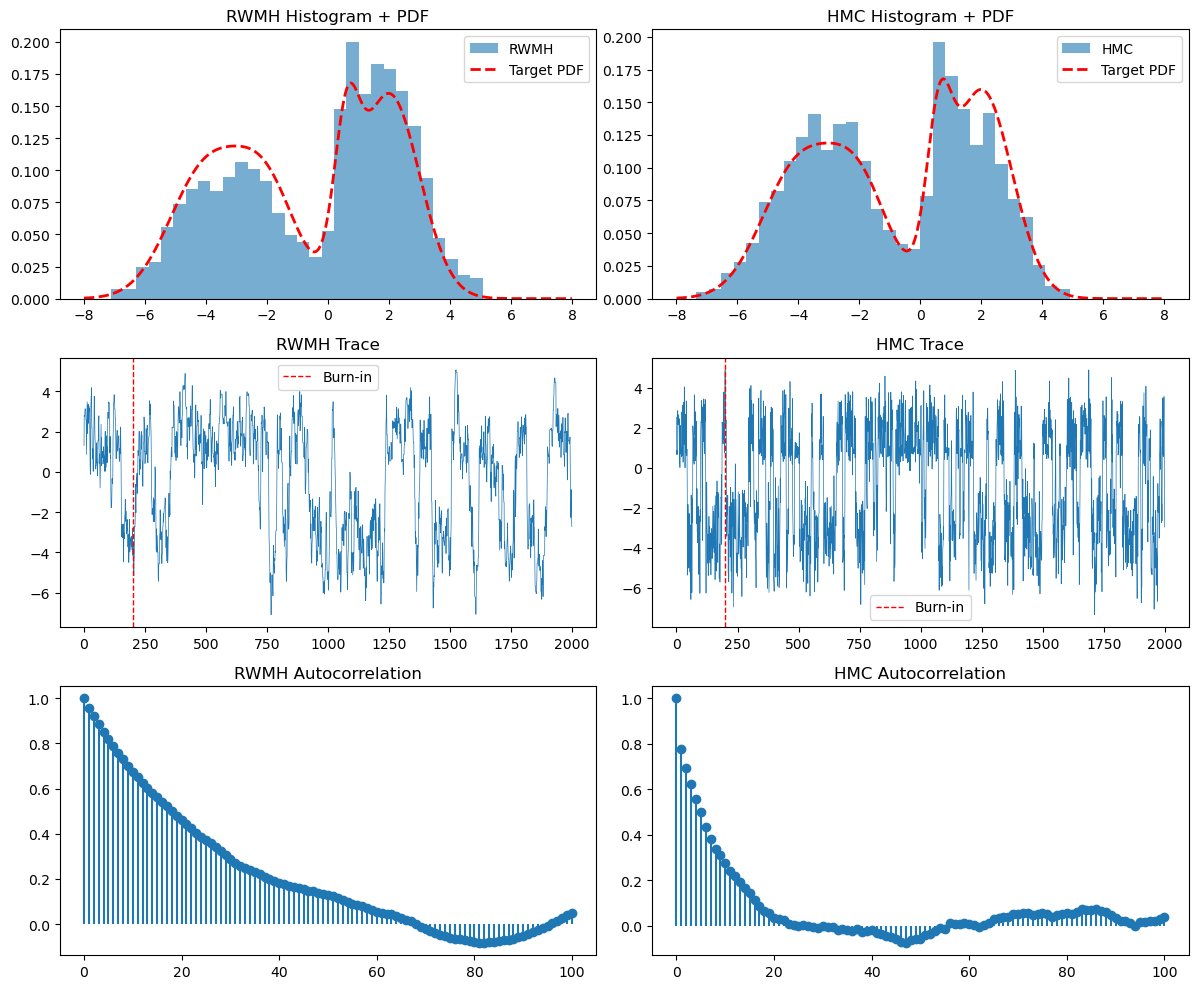

In [10]:
plot_sampler_comparison(rwmh_samples, hmc_samples, target, bins=30, x_range=(-8,8), max_lag=100)

1. RWMH is fast but less efficient per sample

    - It only requires evaluating the target density once per proposal.

    - Acceptance rate is moderate (~0.8).

    - Autocorrelation between samples is higher, so you need more samples to get independent draws.

2. HMC is slower but produces more independent samples

    - Each iteration requires multiple gradient evaluations (one per leapfrog step), which explains the 19 seconds vs 0.46 seconds.

    - Acceptance rate is extremely high (~0.998), so almost every proposal is accepted.

    - Autocorrelation between samples is much lower, meaning fewer iterations are needed for independent samples.

3. Dimensionality matters

    - In 1D, the overhead of computing gradients dominates. HMC is overkill here.

    - In higher-dimensional problems (like Bayesian neural networks), RWMH becomes very inefficient, and HMC scales much better.

**Rules of thumb:**

- For low-dimensional targets, simple methods like RWMH are often faster in wall-clock time.

- For moderate to high dimensions or strongly correlated targets, HMC is much more efficient per independent sample.

## What happens when HMC is used to train Bayesian Neural Networks?

Number of parameters: 4353
RWMH done in 4.42s, acceptance=0.5557
HMC done in 6.01s, acceptance=0.6100


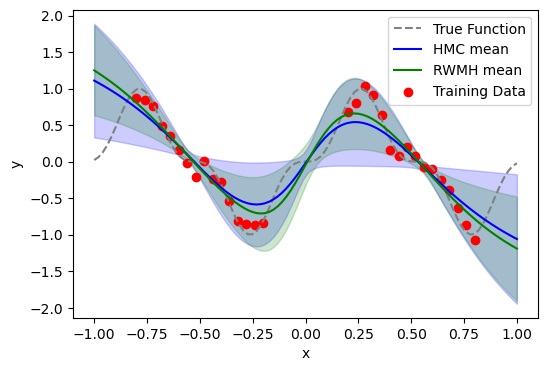

In [11]:
from torch import nn

# -------------------------------
# 1. Toy 1D regression problem
# -------------------------------
torch.manual_seed(0)

def cubic_sin(x: torch.Tensor, noise_std: float = 0.1) -> torch.Tensor:
    y = torch.sin(6*x)**3 + torch.randn_like(x) * noise_std
    return y.reshape((-1, 1))

# Training data: two disjoint intervals
sample_x1 = torch.linspace(-0.8, -0.2, 16).reshape((-1,1))
sample_x2 = torch.linspace(0.2, 0.8, 16).reshape((-1,1))
sample_x = torch.cat([sample_x1, sample_x2], dim=0)

# Scale inputs
x_mean, x_std = sample_x.mean(), sample_x.std()
sample_x_scaled = (sample_x - x_mean) / x_std

# Noisy outputs
sample_y = cubic_sin(sample_x, noise_std=0.1)
y_mean, y_std = sample_y.mean(), sample_y.std()
sample_y_scaled = (sample_y - y_mean) / y_std

# -------------------------------
# 2. Simple 2 hidden layer BNN
# -------------------------------
# ======================================================
# Bayesian Neural Network (just the architecture)
# ======================================================
class BNN(nn.Module):
    """A two-layer MLP with tanh activations"""
    def __init__(self, input_dim=1, hidden_dim1=64, hidden_dim2=64, output_dim=1):
        super(BNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        """Forward pass"""
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return self.fc3(x)


# ======================================================
# Posterior wrapper: adds prior, likelihood, posterior
# ======================================================
#class BNN_Posterior:
#    def __init__(self, model, X, y, prior_mu=0.0, prior_sigma=1.0, noise_sigma=0.1, device="cpu"):
#        """
#        model       : instance of BNN
#        X, y        : data
#        prior_mu    : prior mean (Gaussian)
#        prior_sigma : prior std (Gaussian)
#        noise_sigma : likelihood noise std (aleatoric uncertainty)
#        """
#        self.model = model.to(device)
#        self.X = X.to(device)
#        self.y = y.to(device)
#        self.device = device
#
#        # Priors
#        self.prior_mu = prior_mu
#        self.prior_sigma = prior_sigma
#        self.noise_sigma = noise_sigma
#
#    def neg_log_prior(self):
#        """Negative log prior over weights and biases"""
#        prior_loss = 0.0
#        for m in self.model.modules():
#            if isinstance(m, nn.Linear):
#                dist = torch.distributions.Normal(self.prior_mu, self.prior_sigma)
#                prior_loss += dist.log_prob(m.weight).sum() + dist.log_prob(m.bias).sum()
#        return -prior_loss
#
#    def neg_log_likelihood(self):
#        """Negative log likelihood (Gaussian likelihood on y)"""
#        preds = self.model(self.X)
#        dist = torch.distributions.Normal(preds, self.noise_sigma)
#        return -dist.log_prob(self.y).sum()
#
#    def neg_log_posterior(self):
#        """Negative log posterior = NLL + NLogPrior"""
#        return self.neg_log_likelihood() + self.neg_log_prior()

    
#class BNNPosterior:
#    def __init__(self, model, X, y, noise_std=0.1, prior_mu=0.0, prior_std=1.0, device='cpu'):
#        """
#        Class that outputs negative log-posterior. Uses Gaussian likelihood and prior.
#        The class can also return negative log-prior and the negative log-likelihood.
#        model       : instance of BNN
#        X, y        : data
#        prior_mu    : Gaussian prior mean
#        prior_sigma : Gaussian prior std
#        noise_std : likelihood noise std (aleatoric uncertainty)
#        """
#        self.model = model.to(device)
#        self.X = X.to(device)
#        self.y = y.to(device)
#        self.noise_std = noise_std
#        self.prior_mu = prior_mu
#        self.prior_std = prior_std
#        self.device = device
#
#    def neg_log_prior(self, params):
#        """Compute negative log-prior (Gaussian over all parameters)."""
#        dist = torch.distributions.Normal(self.prior_mu, self.prior_std)
#        return -dist.log_prob(params).sum()
#
#    def neg_log_likelihood(self, params):
#        """Compute negative log-likelihood under Gaussian observation noise."""
#        assign_params(self.model, params)
#        y_pred = self.model(self.X).squeeze()
#        dist = torch.distributions.Normal(y_pred, self.noise_std)
#        return -dist.log_prob(self.y).sum()
#
#    def __call__(self, params):
#        """Negative log-posterior = NLL + NLPrior."""
#        return self.neg_log_prior(params) + self.neg_log_likelihood(params)

# ======================================================
# BNN Posterior with scaled inputs/outputs
# ======================================================
class BNNPosterior:
    def __init__(self, model, X, y, noise_std=0.1, prior_mu=0.0, prior_std=1.0, device='cpu'):
        """
        Class that outputs negative log-posterior. Uses Gaussian likelihood and prior.
        The class can also return the PPD, negative log-prior and the negative log-likelihood.
        model       : instance of BNN
        X_scaled    : scaled inputs
        y_scaled    : scaled outputs
        y_mean      : mean of original targets
        y_std       : std of original targets
        prior_mu    : Gaussian prior mean
        prior_std   : Gaussian prior std
        noise_std   : likelihood noise std in scaled space
        """
        self.model = model.to(device)
        self.X = X.to(device)
        self.y = y.to(device)
        self.noise_std = noise_std
        self.prior_mu = prior_mu
        self.prior_std = prior_std
        self.device = device

    def neg_log_prior(self, params):
        """Negative log-prior ignoring normalization constant"""
        return 0.5 * torch.sum((self.prior_mu-params)**2) / self.prior_std**2

    def neg_log_likelihood(self, params):
        """Negative log-likelihood ignoring normalization constant"""
        assign_params(self.model, params)
        y_pred = self.model(self.X)
        return 0.5 * torch.sum((self.y - y_pred)**2) / self.noise_std**2

    def __call__(self, params):
        """Negative log-posterior = NLL + NLogPrior"""
        return self.neg_log_prior(params) + self.neg_log_likelihood(params)

#def posterior_predictive(samples, model, X_scaled, y_mean, y_std):
#    """
#    Compute posterior predictive mean and standard deviation.
#
#    Inputs:
#        samples   : tensor of shape [num_samples, num_params]
#        model     : BNN instance
#        X_scaled  : scaled inputs (torch.Tensor)
#        y_mean    : mean of original targets
#        y_std     : std of original targets
#    Returns:
#        mean_pred : posterior predictive mean (original scale)
#        std_pred  : posterior predictive std (original scale)
#    """
#    preds = []
#    for theta in samples:
#        assign_params(model, theta)
#        with torch.no_grad():
#            y_pred_scaled = model(X_scaled)
#            # rescale predictions back to original output scale
#            y_pred = y_pred_scaled * y_std + y_mean
#            preds.append(y_pred.cpu())
#    preds = torch.stack(preds)
#    mean_pred = preds.mean(0)
#    std_pred = preds.std(0)
#    return mean_pred, std_pred

def posterior_predictive(param_samples, model, X_scaled, y_mean, y_std):
    """
    Compute posterior predictive mean and std given flat parameter samples (HMC/RWMH style).

    Parameters
    ----------
    param_samples : torch.Tensor
        Tensor of shape [num_samples, num_params].
    model : nn.Module
        BNN model to assign parameters to.
    X_scaled : torch.Tensor
        Input features.
    y_mean, y_std : scalars or tensors
        Scaling for target variable.

    Returns
    -------
    pred_mean, pred_std : np.ndarray
        Predictive mean and std over samples.
    """
    responses = []

    for theta in param_samples:
        assign_params(model, theta)  # sets model parameters from flat vector
        model.eval()
        with torch.no_grad():
            y_pred_scaled = model(X_scaled)
            y_pred = y_pred_scaled * y_std + y_mean
            responses.append(y_pred.cpu().numpy())

    responses = np.array(responses)
    pred_mean = responses.mean(axis=0)
    pred_std = responses.std(axis=0)

    return pred_mean, pred_std



# ======================================================
# Flatten / unflatten parameters of model
# ======================================================
def flatten_params(model):
    """Flatten all model parameters into a single vector"""
    return torch.cat([p.flatten() for p in model.parameters()])

def assign_params(model, flat_params):
    """Load flat parameters back into the model"""
    idx = 0
    for p in model.parameters():
        numel = p.numel()
        p.data = flat_params[idx:idx+numel].view(p.shape).to(p.device)
        idx += numel

# -------------------------------
# 3. Posterior (negative log-posterior)
# -------------------------------
#class BNN_Posterior(nn.Module):
#    def __init__(self, model, X, y, noise_std=1.0, prior_std=1.0):
#        super().__init__()
#        self.model = model
#        self.X = X
#        self.y = y
#        self.noise_std = noise_std
#        self.prior_std = prior_std
#
#    def forward(self, flat_params):
#        assign_params(self.model, flat_params)
#        y_pred = self.model(self.X)
#        log_lik = -0.5 * torch.sum((self.y - y_pred)**2) / self.noise_std**2
#        log_prior = -0.5 * torch.sum(flat_params**2) / self.prior_std**2
#        return - (log_lik + log_prior)  # potential energy

# -------------------------------
# 4. Setup model and posterior
# -------------------------------
# --- Setup BNN model ---
input_dim, hidden_dim1, hidden_dim2, output_dim = 1, 64, 64, 1
model = BNN(input_dim, hidden_dim1, hidden_dim2, output_dim)

# --- Posterior object ---
neg_log_post = BNNPosterior(
    model,
    sample_x_scaled,              # scaled training inputs
    sample_y_scaled,              # training targets
    noise_std=0.1 / y_std.item(), # observation noise
    prior_mu=0.0,                 # mean of Gaussian prior
    prior_std=1.0,                # std of Gaussian prior
    device=device                 # whether you run in CPU or GPU
)

# --- Parameter bookkeeping ---
param_dim = sum(p.numel() for p in model.parameters())
init_params = flatten_params(model).detach()
print(f"Number of parameters: {param_dim}")

# In case you want to print current values of -log-posterior, -log-likelihood and -log-prior
#print("Neg log-posterior:", neg_log_post(init_params).item())
#print("Neg log-prior:", neg_log_post.neg_log_prior(init_params).item())
#print("Neg log-likelihood:", neg_log_post.neg_log_likelihood(init_params).item())

# -------------------------------
# 5. Posterior Predictive
# -------------------------------
#X_test = torch.linspace(-1,1,100).reshape((-1,1))
#X_test_scaled = (X_test - x_mean) / x_std
#y_test = cubic_sin(X_test, noise_std=0)

#def posterior_predictive(samples, model, X_scaled, y_mean, y_std):
#    preds = []
#    for theta in samples:
#        assign_params(model, theta)
#        with torch.no_grad():
#            y_pred_scaled = model(X_scaled)
#            y_pred = y_pred_scaled * y_std + y_mean # Rescale outputs
#            preds.append(y_pred.cpu())
#    preds = torch.stack(preds)
#    mean_pred = preds.mean(0)
#    std_pred = preds.std(0)
#    return mean_pred, std_pred

# -------------------------------
# 6a. RWMH Sampling
# -------------------------------
start_time = time.time()
MH = MetropolisHastings(
    target_distribution=target,
    num_samples=10000, 
    burn_in=200, 
    proposal_std=0.004    # a.k.a. step_size
)
# Adapting MetropolisHastings for BNN: just needs to supply initial flattened params
rwmh_samples = []
x = init_params.clone()
accept_count = 0
for i in range(MH.num_samples + MH.burn_in):
    x_prop = x + torch.randn_like(x) * MH.proposal_std
    p_curr = neg_log_post(x)
    p_prop = neg_log_post(x_prop)
    alpha = torch.clamp(torch.exp(p_curr - p_prop), max=1.0)
    if torch.rand(1) < alpha:
        x = x_prop
        if i >= MH.burn_in:
            accept_count += 1
    if i >= MH.burn_in:
        rwmh_samples.append(x.cpu())
rwmh_samples = torch.stack(rwmh_samples)
rwmh_time = time.time() - start_time
print(f"RWMH done in {rwmh_time:.2f}s, acceptance={accept_count/MH.num_samples:.4f}")

# -------------------------------
# 6b. HMC Sampling
# -------------------------------
start_time = time.time()
hmc = HMC(
    potential_fn=neg_log_post,
    num_dim=param_dim,
    step_size=0.004,
    leapfrog_steps=1,
    num_samples=5000,
    burn_in=20,
    device=device
)
hmc_samples, hmc_acc = hmc.sample(init_position=init_params)
hmc_time = time.time() - start_time
print(f"HMC done in {hmc_time:.2f}s, acceptance={hmc_acc:.4f}")

# -------------------------------
# 7. Calculate Posterior Predictive
# -------------------------------
X_test = torch.linspace(-1,1,100).reshape((-1,1))
X_test_scaled = (X_test - x_mean) / x_std
y_test = cubic_sin(X_test, noise_std=0)

hmc_mean, hmc_std = posterior_predictive(hmc_samples, model, X_test_scaled, y_mean, y_std)
rwmh_mean, rwmh_std = posterior_predictive(rwmh_samples, model, X_test_scaled, y_mean, y_std)

# -------------------------------
# 8. Plot predictions of BNN for both RWMH and HMC
# -------------------------------
def plot_bnn_predictions(X_test, y_true, mean_hmc, std_hmc, mean_rwmh, std_rwmh, sample_x, sample_y):
    fig, ax = plt.subplots(figsize=(6,4))
    
    # True function
    ax.plot(X_test, y_true, '--', color='gray', label='True Function')
    
    # HMC
    ax.plot(X_test, mean_hmc, color='blue', label='HMC mean')
    ax.fill_between(X_test.flatten(), mean_hmc.flatten()-2*std_hmc.flatten(), mean_hmc.flatten()+2*std_hmc.flatten(),
                    color='blue', alpha=0.2)
    
    # RWMH
    ax.plot(X_test, mean_rwmh, color='green', label='RWMH mean')
    ax.fill_between(X_test.flatten(), mean_rwmh.flatten()-2*std_rwmh.flatten(), mean_rwmh.flatten()+2*std_rwmh.flatten(),
                    color='green', alpha=0.2)
    
    # Training points
    ax.scatter(sample_x, sample_y, color='red', label='Training Data')
    
    ax.set_xlabel('x'); ax.set_ylabel('y'); ax.legend()
    plt.show()

plot_bnn_predictions(X_test, y_test, hmc_mean, hmc_std, rwmh_mean, rwmh_std, sample_x, sample_y)

### Stochastic Gradient Langevin Dynamics

There is an interesting method to train BNNs that can be viewed as a simple modification of Stochastic Gradient Descent.

* How can SGD be modified to become a sampler for neural networks, instead of an optimizer? 

## How to improve the efficency of HMC?

**Recall the leap frog update step of HMC**
$$\mathrm{v}_{t+\frac{1}{2}} =\mathrm{v}_{t}-\frac{\eta }{2}\frac{\partial \mathcal{\varepsilon}(\mathrm{\theta}_t)}{\partial \mathrm{\theta}} $$

$$\mathrm{\theta}_{t+1} =  \mathrm{\theta}_{t}+\eta \frac{\partial \mathcal{K}(\mathrm{v}_{t+\frac{1}{2}})}{\partial \mathrm{v}}$$

$$\mathrm{v}_{t+1} =\mathrm{v}_{t+\frac{1}{2}}-\frac{\eta }{2}\frac{\partial \mathcal{\varepsilon}(\mathrm{\theta}_{t+1})}{\partial \mathrm{\theta}} $$

- Only first order information is used!!!
- Accept/Reject makes HMC difficult to work at scale!
- *leapfrog* requires more computational cost!


### From Hamiltonian Dynamics to Langevin dynamics
The update rule of Langevin dynamics modified when considering *leapfrog =1* is given by:

\begin{align}
\label{eq:langevin_update_step}
    \boldsymbol{\theta}_{t+1} 
    &= \boldsymbol{\theta}_{t} 
    - \frac{\eta^2}{2} \boldsymbol{\Sigma}^{-1} \nabla \mathcal{E}(\boldsymbol{\theta}_{t}) 
    + \eta\, \boldsymbol{\Sigma}^{-1} \boldsymbol{v}_{t} \\
    &= \boldsymbol{\theta}_{t} 
    - \frac{\eta^2}{2} \boldsymbol{\Sigma}^{-1} \nabla \mathcal{E}(\boldsymbol{\theta}_{t}) 
    + \eta\, \sqrt{\boldsymbol{\Sigma}^{-1}}\, \boldsymbol{\epsilon}_{t}
\end{align}

where $\boldsymbol{v}_{t} \sim \mathcal{N}(\boldsymbol{0}, \boldsymbol{\Sigma})$ and $\boldsymbol{\epsilon}_{t} \sim \mathcal{N}(\boldsymbol{0}, \boldsymbol{I})$. 

- When $\boldsymbol{\Sigma} = \boldsymbol{I}$ and $\eta = \sqrt{2}$, the update process reduces to a discretized Langevin diffusion, given by:

\begin{equation}
    \mathrm{d}\boldsymbol{\theta}_{t} = - \nabla \mathcal{E}(\boldsymbol{\theta}_{t})\, \mathrm{d}{t} + \sqrt{2}\, \mathrm{d}\boldsymbol{B}_{t}
\end{equation}

where $\boldsymbol{B}_{t}$ denotes a $d$-dimensional Brownian motion.

### Connection between Langevin dynamic with Stochastic Gradient Decent

**Stochastic Gradient Descent (SGD)**
Recall that for a loss function such as MSE, the **full-batch gradient** is:

$$
\nabla_{\boldsymbol{\theta}} \mathcal{L}(\boldsymbol{\theta}) = \frac{1}{N} \sum_{n=1}^{N} \nabla \mathcal{L}_n(\boldsymbol{\theta})
$$



**Mini-Batch Gradient**

In practice, we often use the **mini-batch** technique:

$$
\nabla^B_{\boldsymbol{\theta}} \mathcal{L}(\boldsymbol{\theta}) = \frac{1}{B} \sum_{n=1}^{B} \nabla_{\boldsymbol{\theta}} \mathcal{L}_n(\boldsymbol{\theta})
$$

where:
- $B$ = mini-batch size
- Provides an **unbiased estimate** of the full gradient

### Connection between Langevin dynamic with Stochastic Gradient Decent


**Unbiased:** The mini-batch is randomly sampled from the full dataset:

$$
\mathbb{E}_{\mathcal{B}} \left[ \nabla_{\boldsymbol{\theta}}^{B} \mathcal{L}(\boldsymbol{\theta}) - \nabla_{\boldsymbol{\theta}} \mathcal{L}(\boldsymbol{\theta}) \right] = 0
$$




**Diffusion Term (Variance)**: The variance (covariance matrix) of the gradient difference is:

$$
\mathrm{Cov}_{\mathcal{B}} \left[ \nabla_{\boldsymbol{\theta}}^{B} \mathcal{L}(\boldsymbol{\theta}) - \nabla_{\boldsymbol{\theta}} \mathcal{L}(\boldsymbol{\theta})\right] =
\mathbb{E}_{\mathcal{B}} \left[ \left( \nabla_{\boldsymbol{\theta}}^B \mathcal{L}(\boldsymbol{\theta}) - \nabla_{\boldsymbol{\theta}} \mathcal{L}(\boldsymbol{\theta}) \right) \left( \nabla_{\boldsymbol{\theta}}^B \mathcal{L}(\boldsymbol{\theta}) - \nabla_{\boldsymbol{\theta}} \mathcal{L}(\boldsymbol{\theta}) \right)^\top \right]
$$



For time step $t$, We define

$$
\boldsymbol{v}_t = \sqrt{\lambda} \left( \nabla\mathcal{L}(\boldsymbol{\theta}_t) - \nabla_B\mathcal{L}(\boldsymbol{\theta}_t) \right)
$$

The **SGD update** becomes

$$
\boldsymbol{\theta}_{t+1} = \boldsymbol{\theta}_t - \lambda \nabla^B \mathcal{L}(\boldsymbol{\theta}_t) 
= \boldsymbol{\theta}_t - \lambda \nabla \mathcal{L}(\boldsymbol{\theta}_t) + \sqrt{\lambda} \boldsymbol{v}_t
$$
where $\lambda$ is the learning rate

### Connection between Langevin dynamic with Stochastic Gradient Decent

**SGD update step**
$$\boldsymbol{\theta}_{t+1} =  \boldsymbol{\theta}_t - \lambda \nabla \mathcal{L}(\boldsymbol{\theta}_t) + \sqrt{\lambda} \boldsymbol{v}_t$$

where $\lambda$ is the learning rate, and $\boldsymbol{v}$ is a diffusion term between mini-batch and full batch.

**Langevin update**

$$
\boldsymbol{\theta}_{t+1} = \boldsymbol{\theta}_t - \frac{\eta^2}{2} \nabla \mathcal{E}(\boldsymbol{\theta}_t) + \eta \, \epsilon_t
$$

where $\eta$ is the step size, and $\epsilon_t$ is the diffusion term following a distribution, usually Gaussian.



**Note: Langevin update can be regarded as injecting noise to SGD, such that SGD can be a sampler**

### Stochastic Gradient Langevin Dynamics (SGLD)

Welling et al. (2011) proposed **SGLD**, a special case of Langevin Monte Carlo (LMC) for posterior inference in BNNs.

- Remind the BNN Posterior:$
p(\boldsymbol{\theta} \mid \mathcal{D}) \propto p(\boldsymbol{\theta}) \prod_{n=1}^{N} p(y_n \mid \boldsymbol{\theta})$
- and: $\mathcal{E}(\boldsymbol{\theta}) = - \mathrm{log} p(\boldsymbol{\theta} \mid \mathcal{D})$


- SGLD update rule

$$
\Delta \boldsymbol{\theta}_t = \frac{\epsilon_t}{2} \nabla\left( \log p(\boldsymbol{\theta}_t ) + \frac{N}{B} \log p(y_i \mid \boldsymbol{\theta}_t)\right) + \eta_t \mathbf{I}
$$

where:

$$
\eta_t \sim \mathcal{N}(\boldsymbol{0}, \epsilon_t)
$$

**It anables to sample posteriors of BNN effiently and at scale**

## Summary of SGLD

- Randomly initialize parameters $\boldsymbol{\theta}_0$
- At each iteration $t$:
  1. Sample a **mini-batch** $\mathcal{B}_t$ from the dataset
  2. Compute stochastic gradient of log-posterior and update with noise:
     $$
     \boldsymbol{\theta}_{t+1} =
     \boldsymbol{\theta}_t +
     \frac{\epsilon_t}{2} \left[
     \nabla \log p(\boldsymbol{\theta}_t) +
     \frac{N}{n} \sum_{i \in \mathcal{B}_t}
     \nabla_{\boldsymbol{\theta}} \log p(y_i \mid \boldsymbol{\theta}_t)
     \right]
     +
     \boldsymbol{\eta}_t
     $$
     where $\boldsymbol{\eta}_t \sim \mathcal{N}(\boldsymbol{0}, \epsilon_t \mathbf{I})$
- After **burn-in**, collect samples $\{\boldsymbol{\theta}_t\}$ as posterior samples. Note that, it works fine with collecting every sample after **burn-in**, but set sample frequency that mimics *leapfrog* of HMC could stablize the sampling. 
- Step size $\epsilon_t$ can be constant (for sampling) or decreasing (for convergence)


### Can we further improve SGLD? 

SGLD works well for large-scale problems like training BNNs. However, it **assumes all parameters** $\boldsymbol{\theta}$ have the same step size.
- Slow convergence
- Even divergence when components of $\boldsymbol{\theta}$ have different curvatures



###  Preconditioned SGLD (pSGLD)

Li et al. (2015) proposed **pSGLD** to address this issue with the following refinements.
- Use a **preconditioning matrix** $G(\boldsymbol{\theta}_t)$ (from RMSprop)  



### pSGLD update rule

$$
\Delta \boldsymbol{\theta}_t =
\frac{\epsilon_t}{2} \left[
G(\boldsymbol{\theta}_t)
\left(\nabla \log p(\boldsymbol{\theta}_t) + \frac{N}{n} \log p(y_i \mid \boldsymbol{\theta}_t) \right)
+ \boldsymbol{\Gamma}(\boldsymbol{\theta}_t)
\right]
+ \eta_t G(\boldsymbol{\theta}_t)
$$

where:

$$
\Gamma_i(\boldsymbol{\theta}) = \sum_j \frac{\partial G_{i,j}(\boldsymbol{\theta})}{\partial \theta_j}
$$

- Preconditioner Definition

$$
G(\boldsymbol{\theta}_{t+1}) =
\mathrm{diag} \left(
\boldsymbol{1} \oslash
\left( \lambda \boldsymbol{1} + \sqrt{V(\boldsymbol{\theta}_{t+1})} \right)
\right)
$$

$$
V(\boldsymbol{\theta}_{t+1}) =
\alpha V(\boldsymbol{\theta}_t) +
(1 - \alpha)\,
\bar{g}(\boldsymbol{\theta}_t; \mathcal{B}_t)
\odot
\bar{g}(\boldsymbol{\theta}_t; \mathcal{B}_t)
$$

$$
\bar{g}(\boldsymbol{\theta}_t; \mathcal{B}_t) =
\frac{1}{n} \sum_{i=1}^{n}
\nabla_{\boldsymbol{\theta}} \log p(y_i \mid \boldsymbol{\theta}_t)
$$



In [12]:
import copy
import torch

class SGLDSampler:
    """
    SGLD / pSGLD sampler that updates the model in-place and stores model snapshots.

    Parameters
    ----------
    model : nn.Module
        The Bayesian neural network.
    neg_log_post : object
        Must implement __call__(theta), neg_log_likelihood(theta), neg_log_prior(theta).
    lr : float
        Learning rate.
    precondition : bool
        If True, use preconditioned SGLD (pSGLD).
    alpha : float
        EMA coefficient for squared gradients (pSGLD only).
    eps : float
        Numerical stability (pSGLD only).
    """
    def __init__(self, model, neg_log_post, lr=1e-3, precondition=False, alpha=0.99, eps=1e-5):
        self.model = model
        self.neg_log_post = neg_log_post
        self.lr = lr
        self.precondition = precondition
        self.alpha = alpha
        self.eps = eps
        self.state = {}  # per-parameter preconditioning

    def step(self):
        """Perform one SGLD/pSGLD step on the model parameters."""
        self.model.zero_grad()
        # compute negative log-posterior
        theta = flatten_params(self.model)
        loss = self.neg_log_post(theta)
        loss.backward()

        # update parameters in-place
        for p in self.model.parameters():
            if p.grad is None:
                continue
            grad = p.grad.data

            if self.precondition:
                # initialize state
                if p not in self.state:
                    self.state[p] = torch.zeros_like(p.data)
                V = self.state[p]
                V.mul_(self.alpha).addcmul_(grad, grad, value=1 - self.alpha)
                G = (V + self.eps).sqrt()
                noise = torch.randn_like(p.data) * torch.sqrt(self.lr / G)
                p.data.addcdiv_(grad, G, value=-self.lr/2)
                p.data.add_(noise)
            else:
                noise = torch.randn_like(p.data) * self.lr**0.5
                p.data.add_(-0.5 * self.lr * grad + noise)

        return loss.item()

    def sample(self, num_samples=1000, burn_in=100, sample_freq=10, log_interval=100):
        """Run the sampler and collect parameter vectors."""
        samples = []
        log_likelihoods = []

        for i in range(burn_in + num_samples * sample_freq):
            loss_val = self.step()

            if i % log_interval == 0:
                nll = self.neg_log_post.neg_log_likelihood(flatten_params(self.model)).item()
                prior = self.neg_log_post.neg_log_prior(flatten_params(self.model)).item()
                print(f"[Step {i:5d}] NegLogPosterior: {loss_val:.2f} | "
                      f"NLL: {nll:.2f} | NegLogPrior: {prior:.2f}")

            if i >= burn_in and (i - burn_in) % sample_freq == 0:
                # store flattened parameter vector
                samples.append(flatten_params(self.model).detach().clone())
                log_likelihoods.append(-self.neg_log_post.neg_log_likelihood(flatten_params(self.model)).item())

        return torch.stack(samples), log_likelihoods

In [13]:
sgld = SGLDSampler(model, neg_log_post, lr=1e-3, precondition=True, alpha=0.99, eps=1e-5)
samples, log_liks = sgld.sample(num_samples=1000, burn_in=500, sample_freq=20)

mean_pred, std_pred = posterior_predictive(samples, model, X_test_scaled, y_mean, y_std)


[Step     0] NegLogPosterior: 257.84 | NLL: 1675.72 | NegLogPrior: 261.17
[Step   100] NegLogPosterior: 364.34 | NLL: 45.83 | NegLogPrior: 332.28
[Step   200] NegLogPosterior: 427.65 | NLL: 40.25 | NegLogPrior: 395.10
[Step   300] NegLogPosterior: 485.10 | NLL: 42.80 | NegLogPrior: 435.78
[Step   400] NegLogPosterior: 521.86 | NLL: 36.69 | NegLogPrior: 488.84
[Step   500] NegLogPosterior: 579.71 | NLL: 27.09 | NegLogPrior: 554.05
[Step   600] NegLogPosterior: 647.42 | NLL: 25.54 | NegLogPrior: 607.64
[Step   700] NegLogPosterior: 694.03 | NLL: 34.58 | NegLogPrior: 665.61
[Step   800] NegLogPosterior: 739.97 | NLL: 25.45 | NegLogPrior: 711.61
[Step   900] NegLogPosterior: 792.74 | NLL: 31.12 | NegLogPrior: 763.47
[Step  1000] NegLogPosterior: 821.49 | NLL: 26.40 | NegLogPrior: 800.20
[Step  1100] NegLogPosterior: 891.21 | NLL: 55.45 | NegLogPrior: 857.50
[Step  1200] NegLogPosterior: 936.45 | NLL: 29.10 | NegLogPrior: 910.07
[Step  1300] NegLogPosterior: 994.78 | NLL: 20.53 | NegLogPrio

[Step 11400] NegLogPosterior: 2662.28 | NLL: 12.16 | NegLogPrior: 2646.89
[Step 11500] NegLogPosterior: 2662.30 | NLL: 13.56 | NegLogPrior: 2651.46
[Step 11600] NegLogPosterior: 2694.18 | NLL: 20.13 | NegLogPrior: 2674.23
[Step 11700] NegLogPosterior: 2686.94 | NLL: 17.01 | NegLogPrior: 2670.70
[Step 11800] NegLogPosterior: 2712.62 | NLL: 22.43 | NegLogPrior: 2694.52
[Step 11900] NegLogPosterior: 2743.15 | NLL: 23.55 | NegLogPrior: 2719.00
[Step 12000] NegLogPosterior: 2721.80 | NLL: 29.41 | NegLogPrior: 2708.42
[Step 12100] NegLogPosterior: 2709.41 | NLL: 14.40 | NegLogPrior: 2699.02
[Step 12200] NegLogPosterior: 2709.15 | NLL: 17.11 | NegLogPrior: 2691.29
[Step 12300] NegLogPosterior: 2690.83 | NLL: 18.84 | NegLogPrior: 2671.17
[Step 12400] NegLogPosterior: 2701.69 | NLL: 12.62 | NegLogPrior: 2678.57
[Step 12500] NegLogPosterior: 2691.82 | NLL: 23.32 | NegLogPrior: 2670.38
[Step 12600] NegLogPosterior: 2688.66 | NLL: 18.95 | NegLogPrior: 2671.05
[Step 12700] NegLogPosterior: 2733.27 

In [14]:
def plot_bnn_prediction(X_test, y_true, mean_pred, std_pred, X_train, y_train):
    """
    Plot BNN posterior predictive mean, uncertainty, and training data.

    Parameters
    ----------
    X_test : torch.Tensor or np.ndarray
        Test inputs (original scale).
    y_true : torch.Tensor or np.ndarray
        True function values (original scale).
    mean_pred : np.ndarray
        Predictive mean from posterior predictive [num_points, output_dim].
    std_pred : np.ndarray
        Predictive std (epistemic uncertainty) [num_points, output_dim].
    X_train : torch.Tensor or np.ndarray
        Training inputs (original scale).
    y_train : torch.Tensor or np.ndarray
        Training outputs (original scale).
    """
    X_test_np = X_test.detach().cpu().numpy() if torch.is_tensor(X_test) else X_test
    y_true_np = y_true.detach().cpu().numpy() if torch.is_tensor(y_true) else y_true
    X_train_np = X_train.detach().cpu().numpy() if torch.is_tensor(X_train) else X_train
    y_train_np = y_train.detach().cpu().numpy() if torch.is_tensor(y_train) else y_train

    mean_pred = mean_pred.squeeze()
    std_pred = std_pred.squeeze()

    fig, ax = plt.subplots(figsize=(7, 5))
    
    # True function
    ax.plot(X_test_np, y_true_np, '--', color='gray', label='True Function')
    
    # BNN predictive mean
    ax.plot(X_test_np, mean_pred, color='blue', label='BNN Posterior Mean')
    
    # Epistemic uncertainty
    ax.fill_between(
        X_test_np.flatten(),
        mean_pred - 1.96 * std_pred,
        mean_pred + 1.96 * std_pred,
        color='blue', alpha=0.2,
        label='95% Credible Interval'
    )
    
    # Training data
    ax.scatter(X_train_np, y_train_np, color='red', marker='o', label='Training Data')
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()
    ax.set_title('BNN Posterior Predictive')
    plt.show()

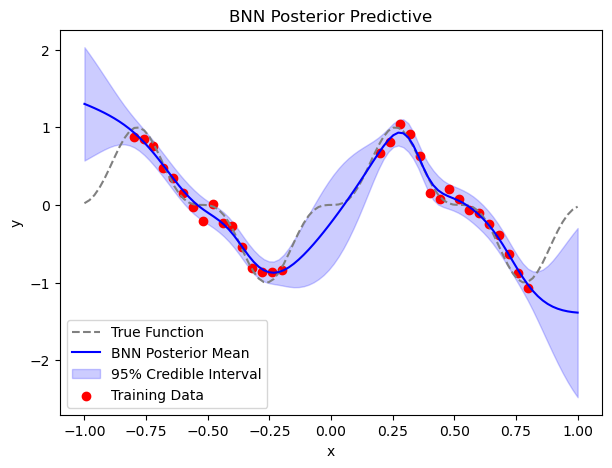

In [15]:
plot_bnn_prediction(X_test=X_test, y_true=y_test, mean_pred=mean_pred,
                    std_pred=std_pred, X_train=sample_x, y_train=sample_y)

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt

device = 'cpu'

# ------------------ pSGLD Sampler ------------------ #
class pSGLDSampler:
    """pSGLD sampler for 1D target distribution."""
    def __init__(self, target_distribution, num_samples=500, burn_in=200, lr=1.0, alpha=0.99, eps=1e-5):
        self.target = target_distribution
        self.num_samples = num_samples
        self.burn_in = burn_in
        self.lr = lr
        self.alpha = alpha
        self.eps = eps

    def run(self, num_trials=1, x0=None):
        self.trial_samples = []
        self.full_chains = []

        for trial in range(num_trials):
            g = torch.Generator(device=device).manual_seed(123 + trial)
            x = torch.randn((), generator=g, device=device) if x0 is None else torch.as_tensor(x0, device=device).reshape(())
            V = torch.tensor(0., device=device)  # EMA of squared gradients
            samples, full_chain = [], []

            for i in range(self.num_samples + self.burn_in):
                # compute gradient of negative log PDF
                x_var = x.clone().requires_grad_(True)
                loss = self.target.neg_log_pdf(x_var)
                loss.backward()
                grad = x_var.grad

                # update EMA
                V.mul_(self.alpha).addcmul_(grad, grad, value=1 - self.alpha)
                G = (V + self.eps).sqrt()
                noise = torch.randn((), generator=g, device=device) * torch.sqrt(self.lr / G)
                x = x - 0.5 * self.lr * grad / G + noise

                full_chain.append(x.item())
                if i >= self.burn_in:
                    samples.append(x.item())

            self.trial_samples.append(torch.tensor(samples, device=device))
            self.full_chains.append(torch.tensor(full_chain, device=device))

        return self.trial_samples

    # ------------------ Autocorrelation ------------------ #
    @staticmethod
    def autocorrelation(x, max_lag=100):
        x = np.asarray(x)
        x = x - np.mean(x)
        result = np.correlate(x, x, mode='full')
        acf = result[result.size//2:]
        acf = acf / acf[0]
        return acf[:max_lag+1]

    # ------------------ Plotting ------------------ #
    def plot_trials(self, bins=30, x_range=(-10,10), num_points=1000, max_lag=100):
        x_plot = torch.linspace(*x_range, num_points, device=device)
        pdf = self.target.pdf(x_plot).cpu().numpy()

        for i, (samples, chain) in enumerate(zip(self.trial_samples, self.full_chains)):
            fig = plt.figure(figsize=(12,4))
            gs = fig.add_gridspec(1, 2, width_ratios=[2,1])

            # Left: histogram + PDF
            ax0 = fig.add_subplot(gs[0,0])
            ax0.hist(samples.cpu().numpy(), bins=bins, density=True, alpha=0.6, label='Samples')
            ax0.plot(x_plot.cpu().numpy(), pdf, 'r--', lw=2, label='Target PDF')
            ax0.set_xlabel('x'); ax0.set_ylabel('Density'); ax0.set_title(f'Trial {i+1}: Histogram + PDF')
            ax0.legend()

            # Right: trace + autocorrelation
            gs_right = gs[0,1].subgridspec(2,1,hspace=0.7)

            # Trace plot
            ax1 = fig.add_subplot(gs_right[0,0])
            ax1.plot(chain.cpu().numpy(), lw=0.5)
            ax1.axvline(self.burn_in, color='red', ls='--', lw=1, label="Burn-in cutoff")
            ax1.set_xlabel('Iteration'); ax1.set_ylabel('x'); ax1.set_title('Trace plot'); ax1.legend()

            # Autocorrelation plot
            ax2 = fig.add_subplot(gs_right[1,0])
            acf = self.autocorrelation(samples.cpu().numpy(), max_lag=max_lag)
            ax2.stem(range(len(acf)), acf)
            ax2.set_xlabel('Lag'); ax2.set_ylabel('Autocorrelation'); ax2.set_title('Sample Autocorrelation')

            plt.tight_layout(); plt.show()


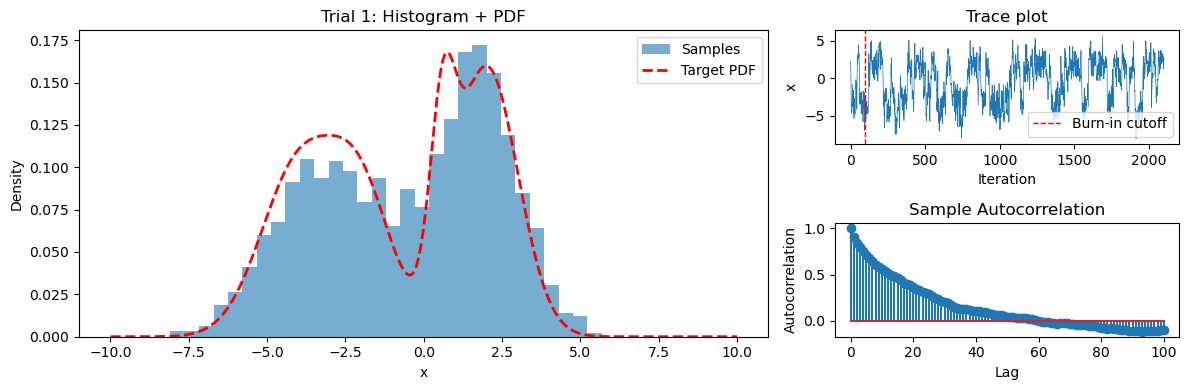

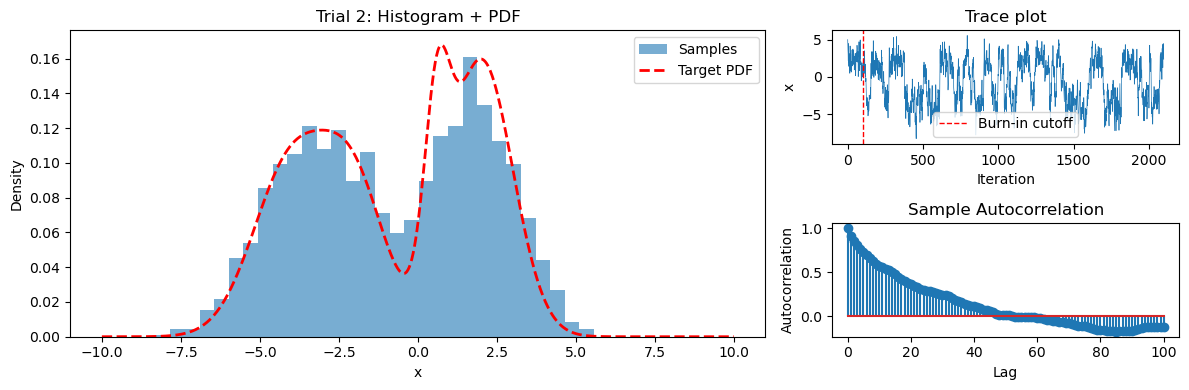

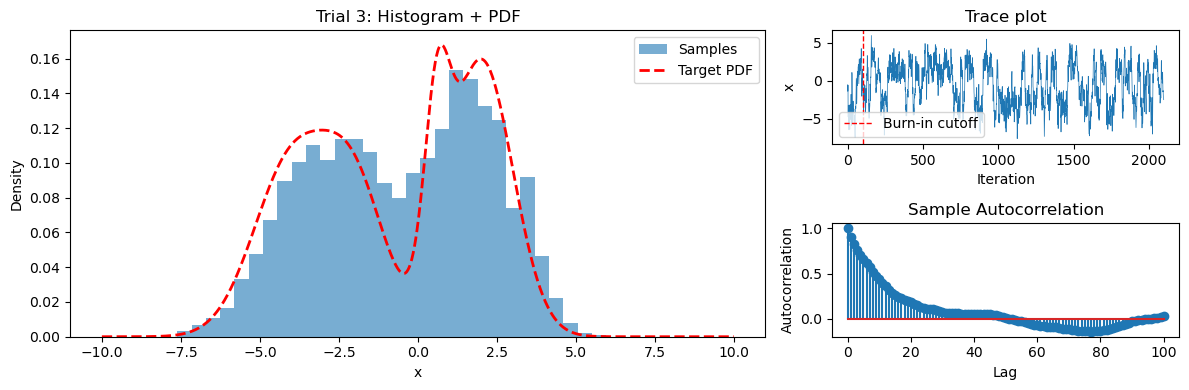

In [20]:
sampler = pSGLDSampler(target, num_samples=2000, burn_in=100, lr=1.0, alpha=0.95, eps=1e-2)
samples = sampler.run(num_trials=3)
sampler.plot_trials(max_lag=100)

### See you next class

Have fun!